# 한글 텍스트 분류

 - 한글과 영어는 각기 언어적인 특성이 매우 달라서 언어를 처리하는 과정이 다르다.
 - 지금까지 사용한 자연어 처리 라이브러리(NLTK)는 한글 텍스트를 지원하지 않는다.
 - 따라서, 한글 자연어 처리를 도와주는 파이썬 라이브러리인  KoNLPy를 활용한다.

# 데이터 소개

 - 데이터 이름 : Naver sentiment movie corpus v1.0
 - 데이터 용도 : 텍스트 분류 학습을 목적으로 사용한다.
 - 데이터 권환 : CC0 1.0
 - 데이터 출처 : https://github.com/e9t/nsmc

# 문제소개

- 영어는 데이터가 많고 참고 자료도 풍부하고 쉽게 찾아볼 수 있다. 하지만 한글은 데이터도 많지 않고 한글 자연어 처리와 관련됨 참고 자료 또한 많지 않아서 공부하는 데 어려움이 있다. 다행히도 몇 가지 데이터가 공개되어 있는데 그 중 하나가 바로 네이버 영화 리뷰 데이터인 "Naver sentiment movie corpus v1.0"이다.
- 이 데이터는 네이버 영화의 사용자 리뷰를 각 영화당 100개씩 모아서 만들어진 데이터다. 이전 장에서 살펴본 영화 리뷰 데이터와 같은 구조로 되어 있으며, 감정의 경우에는 긍정 혹은 부정의 값을 가진다.

# 데이터 구성

- rating.txt : 전체 리뷰를 모아둔 데이터, 전체 20만 개의 데이터로 구성되어 있다.
- ratings_train.txt : 학습 데이터, 총 15만 개의 데이터로 구성되어 있다.
- ratings_test.txt : 평가 데이터, 총 5만 개의 데이터로 구성되어 있다.

# 라이브러리

In [1]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
%matplotlib inline

# 데이터 크기 확인

In [2]:
DATA_IN_PATH = './data_in/'
print("파일 크기 : ")
for file in os.listdir(DATA_IN_PATH):
    if 'txt' in file :
        print(file.ljust(30) + str(round(os.path.getsize(DATA_IN_PATH + file) / 1000000, 2)) + 'MB')

파일 크기 : 
ratings.txt                   19.52MB
ratings_test.txt              4.89MB
ratings_train.txt             14.63MB


# Train Data 확인

In [3]:
# 한글 영화 리뷰 데이터의 경우 3개의 열(column)으로 이루어져 있다.
# 각각 id, 내용이 담긴 document, 긍정 부정을 나타내는 label 값을 가지고 있다.
train_data = pd.read_csv(DATA_IN_PATH + 'ratings_train.txt', header = 0, delimiter = '\t', quoting = 3)
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


#  Train Data 개수 확인

In [4]:
print('전체 학습데이터의 개수: {}'.format(len(train_data)))

전체 학습데이터의 개수: 150000


# 각 리뷰 데이터들의 길이 확인

In [5]:
train_lenght = train_data['document'].astype(str).apply(len)
train_lenght.head()

0    19
1    33
2    17
3    29
4    61
Name: document, dtype: int64

# 각 리뷰 데이터에 대해 길이에 대한 히스토그램

Text(0, 0.5, 'Number of review')

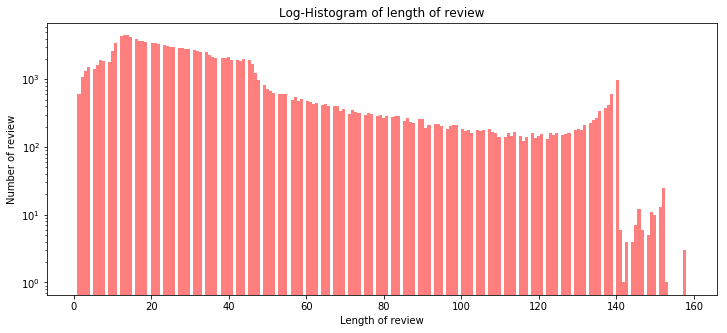

In [6]:
# 그래프에 대한 이미지 사이즈 선언
# figsize: (가로, 세로) 형태의 튜플로 입력
plt.figure(figsize=(12, 5))
# 히스토그램 선언
# bins: 히스토그램 값들에 대한 버켓 범위
# range: x축 값의 범위
# alpha: 그래프 색상 투명도
# color: 그래프 색상
# label: 그래프에 대한 라벨
plt.hist(train_lenght, bins=200, alpha=0.5, color= 'r', label='word')
plt.yscale('log', nonposy='clip')
# 그래프 제목
plt.title('Log-Histogram of length of review')
# 그래프 x 축 라벨
plt.xlabel('Length of review')
# 그래프 y 축 라벨
plt.ylabel('Number of review')


# 길이를 보면 매우 짧은 길이부터 140자까지 고르게 분포되어 있다. 조금 특이한 부분은 보통 20자 이하에 많이 분포되어 있다가
# 길이가 일어질수록 점점 수가 적어지는데, 1140자 부근에서 데이터의 수가 갑자기 많아지는 모습을 보여준다.
# 해당 데이터의 140자 제한(한글 기준)이 있는 데이터이기 때문에 치대 글자수에 조금 모여 있는 형태이다.

# 각 리뷰 데이터에 대한 통계량 값

In [7]:
print('리뷰 길이 최대 값: {}'.format(np.max(train_lenght)))
print('리뷰 길이 최소 값: {}'.format(np.min(train_lenght)))
print('리뷰 길이 평균 값: {:.2f}'.format(np.mean(train_lenght)))
print('리뷰 길이 표준편차: {:.2f}'.format(np.std(train_lenght)))
print('리뷰 길이 중간 값: {}'.format(np.median(train_lenght)))
# 사분위의 대한 경우는 0~100 스케일로 되어있음
print('리뷰 길이 제 1 사분위: {}'.format(np.percentile(train_lenght, 25)))
print('리뷰 길이 제 3 사분위: {}'.format(np.percentile(train_lenght, 75)))


# 글자수 제한은 140이지만 특수 문자 등으로 인해 최대 길이가 158이 나왔다.
# 최솟값은 1이고, 평균의 경우 35자 정도 된다.
# 중간값은 27로 평균보다 좀 더 작은 값을 가진다.

리뷰 길이 최대 값: 158
리뷰 길이 최소 값: 1
리뷰 길이 평균 값: 35.24
리뷰 길이 표준편차: 29.58
리뷰 길이 중간 값: 27.0
리뷰 길이 제 1 사분위: 16.0
리뷰 길이 제 3 사분위: 42.0


# 각 리뷰 데이터에 대한 박스플랏

{'whiskers': [<matplotlib.lines.Line2D at 0x1b357664ac8>,
 'caps': [<matplotlib.lines.Line2D at 0x1b3575df198>,
 'boxes': [<matplotlib.lines.Line2D at 0x1b357664978>],
 'medians': [<matplotlib.lines.Line2D at 0x1b3575df828>],
 'fliers': [<matplotlib.lines.Line2D at 0x1b3575dfe80>],
 'means': [<matplotlib.lines.Line2D at 0x1b3575dfb70>]}

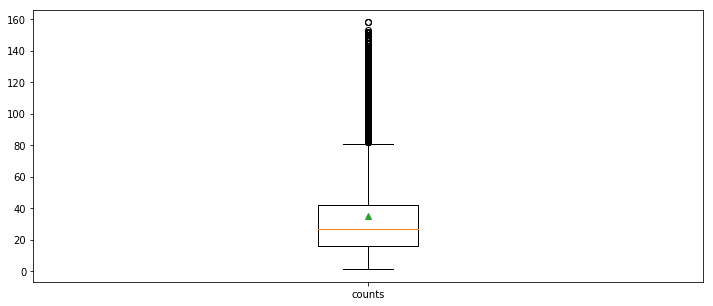

In [8]:
plt.figure(figsize=(12, 5))
# 박스플롯 생성
# 첫번째 파라메터: 여러 분포에 대한 데이터 리스트를 입력
# labels: 입력한 데이터에 대한 라벨
# showmeans: 평균값을 마크함
plt.boxplot(train_lenght, labels=['counts'], showmeans=True)


# 박스플랏을 보면 대부분 일부 길이가 긴 데이터가 꽤 있다는 것을 확인할 수 있다.
# 중간값과 평균값은 전체 데이터로 보면 아래쪽에 위치한다.

# 리뷰 데이터 빈도 분석

In [9]:
# 데이터 안에 들어있는 문자열이 아닌 데이터는 모두 삭제한다.
# 어휘 빈도 분석은 문자열에 대해서만 진행할 수 있기 때문에 다른 형식이 있다면 오류가 발생할 수 있다.
train_review = [review for review in train_data['document'] if type(review) is str]

In [10]:
# 워드클라우드를 만든다.
# 이 때 한글의 경우 폰트를 지정해 주어야 한다.
wordclud = WordCloud(font_path = DATA_IN_PATH + 'NanumGothic.ttf').generate(' '.join(train_review))

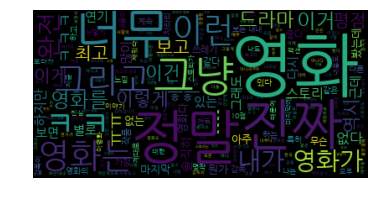

In [11]:
# 워드클라우드를 시각화한다.
plt.imshow(wordclud, interpolation = "bilinear")
plt.axis("off")
plt.show()

# 리뷰 데이터 Label의 비율

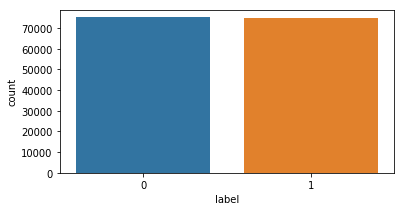

In [12]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(6, 3)
sns.countplot(train_data['label'])

In [13]:
print("긍정 리뷰 개수: {}".format(train_data['label'].value_counts()[1]))
print("부정 리뷰 개수: {}".format(train_data['label'].value_counts()[0]))

긍정 리뷰 개수: 74827
부정 리뷰 개수: 75173


# 각 리뷰의 사용된 단어의 히스토그램

Text(0, 0.5, 'Number of reviews')

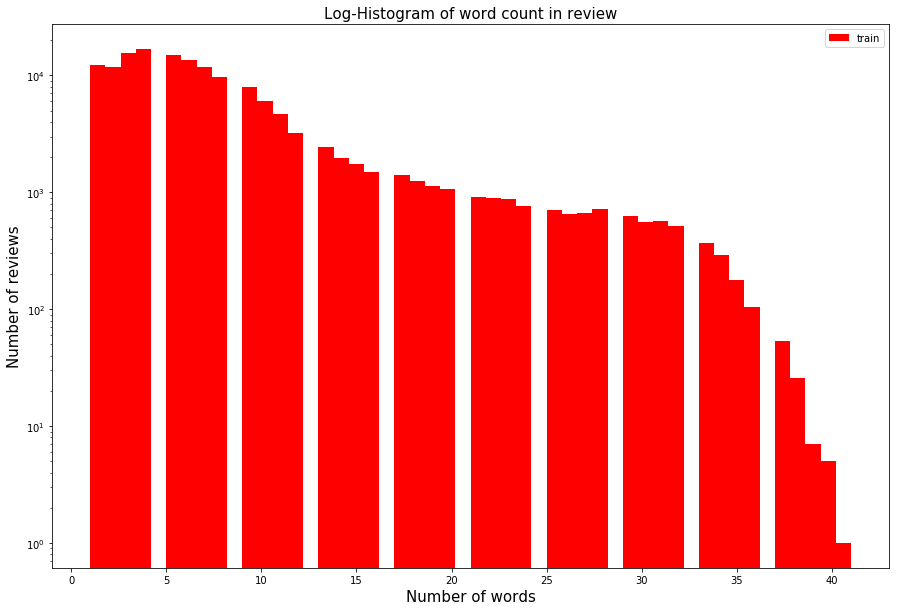

In [14]:
# 각 데이터를 띄어쓰기 기준으로 나눠서 그 개수를 하나의 변수로 할당하고 그 값을 사용해 히스토그램을 그란다.
train_word_counts = train_data['document'].astype(str).apply(lambda x:len(x.split(' ')))

plt.figure(figsize=(15, 10))
plt.hist(train_word_counts, bins=50, facecolor='r',label='train')
plt.title('Log-Histogram of word count in review', fontsize=15)
plt.yscale('log', nonposy='clip')
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Number of reviews', fontsize=15)


# 히스토그램을 보면 대부분 5개 정도에 분포되어 있다. 그 이후로는 거의 고르게 분포되어 있고 30개 이상의 데이터부터는 수가 급격히 줄어든다.

# 각 리뷰에 사용된 단어의 통계량

In [15]:
print('리뷰 단어 개수 최대 값: {}'.format(np.max(train_word_counts)))
print('리뷰 단어 개수 최소 값: {}'.format(np.min(train_word_counts)))
print('리뷰 단어 개수 평균 값: {:.2f}'.format(np.mean(train_word_counts)))
print('리뷰 단어 개수 표준편차: {:.2f}'.format(np.std(train_word_counts)))
print('리뷰 단어 개수 중간 값: {}'.format(np.median(train_word_counts)))
# 사분위의 대한 경우는 0~100 스케일로 되어있음
print('리뷰 단어 개수 제 1 사분위: {}'.format(np.percentile(train_word_counts, 25)))
print('리뷰 단어 개수 제 3 사분위: {}'.format(np.percentile(train_word_counts, 75)))


# 결고를 보면 평균 7~8개의 단어 개수를 가지고 있고, 중간값의 경우 6개 정도의 단어를 가지고 있다.
# 글자수 제하니 있어서 영어 데이터에 비해 길이가 짧은 편이다.
# 이 경우 모델에 적용할 최대 단어 개수를 6개가 아닌 7개로 설정해도 크게 무리는 없을 것이다.

리뷰 단어 개수 최대 값: 41
리뷰 단어 개수 최소 값: 1
리뷰 단어 개수 평균 값: 7.58
리뷰 단어 개수 표준편차: 6.51
리뷰 단어 개수 중간 값: 6.0
리뷰 단어 개수 제 1 사분위: 3.0
리뷰 단어 개수 제 3 사분위: 9.0


# 각 데이터에 대해 특수문자 유무 확인

In [16]:
qmarks = np.mean(train_data['document'].astype(str).apply(lambda x: '?' in x)) # 물음표가 구두점으로 쓰임
fullstop = np.mean(train_data['document'].astype(str).apply(lambda x: '.' in x)) # 마침표                
print('물음표가있는 질문: {:.2f}%'.format(qmarks * 100))
print('마침표가 있는 질문: {:.2f}%'.format(fullstop * 100))

# 영화 리뷰 데이터이기 때문에 물음표의 경우는 거의 포함되어 있지 않지만 마침표의 경우 절반 정도의 데이터가 가지고 있다.

물음표가있는 질문: 8.25%
마침표가 있는 질문: 51.76%


# 데이터 전처리

In [17]:
# 라이브러리
import numpy as np
import pandas as pd
import re
import json
from konlpy.tag import Okt
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.preprocessing.text import Tokenizer

In [18]:
# 데이터 불러오기
# 데이터를 보면 HTML 태그가 없다.
# 따라서 BeatifulSoup 라이브러리를 이용한 태그 제거는 따로 하지 않는다.
# 그러나 특수문자나 숫자 등은 종종 보인다.
DATA_IN_PATH ='./data_in/'
train_data = pd.read_csv(DATA_IN_PATH + 'ratings_train.txt', header=0, delimiter='\t', quoting=3 )
print(train_data.head())

         id                                           document  label
0   9976970                                아 더빙.. 진짜 짜증나네요 목소리      0
1   3819312                  흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나      1
2  10265843                                  너무재밓었다그래서보는것을추천한다      0
3   9045019                      교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정      0
4   6483659  사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...      1


In [19]:
# 첫번째 리뷰에 대해 간단하게 한글만 남긴다.
# 정규표현식을 활용해 한글 문자가 아닌 것들을 모두 제거한다.
review_text = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", "", train_data['document'][0]) 
print(review_text)

아 더빙 진짜 짜증나네요 목소리


In [20]:
# 문장 단어로 분리
# 불용어 제거를 위해 KoNLPy 라이브러리의 okt 객체를 사용한다.
# 그리고, 형태소 분석기를 사용할 때 어간 추출을 사용해 어간이 추출된 단어로 나눈다.
okt=Okt()
review_text = okt.morphs(review_text, stem=True)
print(review_text)

['아', '더빙', '진짜', '짜증나다', '목소리']


In [21]:
# 이제 불용어를 제거한다.
# 따로 불용어 사전이 KoNLPy 라이브러리에 없기 때문에 직접 불용어 사전을 만든다.
stop_words = set(['은', '는', '이', '가', '하', '아', '것', '들','의', '있', '되', '수', '보', '주', '등', '한'])
clean_review = [token for token in review_text if not token in stop_words]
print(clean_review)

['더빙', '진짜', '짜증나다', '목소리']


In [22]:
# 이제 전체 데이터에 적용하기 위해 함수를 만든다.

def preprocessing(review, okt, remove_stopwords = False, stop_words = []):
    # 함수의 인자는 다음과 같다.
    # review : 전처리할 텍스트
    # okt : okt 객체를 반복적으로 생성하지 않고 미리 생성후 인자로 받는다.
    # remove_stopword : 불용어를 제거할지 선택 기본값은 False
    # stop_word : 불용어 사전은 사용자가 직접 입력해야함 기본값은 비어있는 리스트
    
    # 1. 한글 및 공백을 제외한 문자 모두 제거.
    review_text = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", "", review)
    
    # 2. okt 객체를 활용해서 형태소 단위로 나눈다.
    word_review = okt.morphs(review_text, stem=True)
    
    if remove_stopwords:
        
        # 불용어 제거(선택적)
        word_review = [token for token in word_review if not token in stop_words]
        
   
    return word_review

In [23]:
# 전체 Train 데이터에 대한 전처리 적용

stop_words = [ '은', '는', '이', '가', '하', '아', '것', '들','의', '있', '되', '수', '보', '주', '등', '한']
okt = Okt()
clean_train_review = []

for review in train_data['document']:
    # 비어있는 데이터에서 멈추지 않도록 string인 경우만 진행
    if type(review) == str:
        clean_train_review.append(preprocessing(review, okt, remove_stopwords = True, stop_words=stop_words))
    else:
        clean_train_review.append([])  #string이 아니면 비어있는 값 추가

In [29]:
# 전처리된 결과를 보면, 오타가 있는 것이 보이지만 지금 단계에선 수정하지 않고 그대로 놔둔다.
clean_train_review[:4]

[['더빙', '진짜', '짜증나다', '목소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'],
 ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다'],
 ['교도소', '이야기', '구먼', '솔직하다', '재미', '없다', '평점', '조정']]

In [28]:
# Test 데이터에도 같은 전처리를 적용

test_data = pd.read_csv(DATA_IN_PATH + 'ratings_test.txt', header=0, delimiter='\t', quoting=3 )

clean_test_review = []

for review in test_data['document']:
    # 비어있는 데이터에서 멈추지 않도록 string인 경우만 진행
    if type(review) == str:
        clean_test_review.append(preprocessing(review, okt, remove_stopwords = True, stop_words=stop_words))
    else:
        clean_test_review.append([])  #string이 아니면 비어있는 값 추가

In [30]:
# 전처리된 결과를 보면, 오타가 있는 것이 보이지만 지금 단계에선 수정하지 않고 그대로 놔둔다.
clean_test_review[:4]

[['굳다', 'ㅋ'],
 [],
 ['뭐', '야', '평점', '나쁘다', '않다', '점', '짜다', '리', '더', '더욱', '아니다'],
 ['지루하다', '않다', '완전', '막장', '임', '돈', '주다', '보기', '에는']]

In [33]:
# 이제 인덱스 벡터로 바꾼 후 패딩 처리만 하면 된다.
# 텐서플로의 전처리 모듈을 사용하는데 토크나이징 객체를 만든 후 학습 데이터에 대해서만 적용하고 해당 객체를 사용해서
# 두 데이터를 인덱스 벡터로 만든다.

# 그런다음, 마지막으로 해당 데이터들을 패딩 처리하면 된다.

In [34]:
# 문장 토크나이징
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_train_review)
train_sequences = tokenizer.texts_to_sequences(clean_train_review)
test_sequences = tokenizer.texts_to_sequences(clean_test_review)

# 단어 사전 형태
word_vocab = tokenizer.word_index 

# 문장 최대 길이
MAX_SEQUENCE_LENGTH = 8

# 학습 데이터를 벡터화
train_inputs = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
# 학습 데이터의 라벨
train_labels = np.array(train_data['label'])

# 테스트 데이터를 벡터화
test_inputs = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
# 테스트 데이터의 라벨
test_labels = np.array(test_data['label'])

In [35]:
# 전처리가 끝난 데이터를 파일로 저장

DATA_IN_PATH = './data_in/'
TRAIN_INPUT_DATA = 'nsmc_train_input.npy'
TRAIN_LABEL_DATA = 'nsmc_train_label.npy'
TEST_INPUT_DATA = 'nsmc_test_input.npy'
TEST_LABEL_DATA = 'nsmc_test_label.npy'
DATA_CONFIGS = 'data_configs.json'

data_configs = {}

data_configs['vocab'] = word_vocab
data_configs['vocab_size'] = len(word_vocab) # vocab size 추가

import os
# 저장하는 디렉토리가 존재하지 않으면 생성
if not os.path.exists(DATA_IN_PATH):
    os.makedirs(DATA_IN_PATH)

# 전처리 된 학습 데이터를 넘파이 형태로 저장
np.save(open(DATA_IN_PATH + TRAIN_INPUT_DATA, 'wb'), train_inputs)
np.save(open(DATA_IN_PATH + TRAIN_LABEL_DATA, 'wb'), train_labels)
# 전처리 된 테스트 데이터를 넘파이 형태로 저장
np.save(open(DATA_IN_PATH + TEST_INPUT_DATA, 'wb'), test_inputs)
np.save(open(DATA_IN_PATH + TEST_LABEL_DATA, 'wb'), test_labels)

# 데이터 사전을 json 형태로 저장
json.dump(data_configs, open(DATA_IN_PATH + DATA_CONFIGS, 'w'), ensure_ascii=False)

# 모델링

In [36]:
# 라이브러리
import os
from datetime import datetime
import tensorflow as tf
import numpy as np
import json
from sklearn.model_selection import train_test_split

In [37]:
# 전처리한 데이터 불러오기
DATA_IN_PATH = './data_in/'
DATA_OUT_PATH = './data_out/'
INPUT_TRAIN_DATA = 'nsmc_train_input.npy'
LABEL_TRAIN_DATA = 'nsmc_train_label.npy'
DATA_CONFIGS = 'data_configs.json'

input_data = np.load(open(DATA_IN_PATH + INPUT_TRAIN_DATA, 'rb'))
label_data = np.load(open(DATA_IN_PATH + LABEL_TRAIN_DATA, 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))

In [53]:
# 하이퍼 파라미터 정의
TEST_SPLIT = 0.1
RNG_SEED = 13371447
VOCAB_SIZE = prepro_configs['vocab_size']
EMB_SIZE = 128
BATCH_SIZE = 16
NUM_EPOCHS = 10

# Train과 Validation 분리
# Train = 90%, Validation = 10%
input_train, input_eval, label_train, label_eval = train_test_split(input_data, label_data, test_size=TEST_SPLIT, random_state=RNG_SEED)

In [54]:
# 데이터 입력 함수
# 에스티메이터에 데이터를 적용하기 위해 데이터 입력 함수를 정의한다.

def mapping_fn(X, Y):
    input, label = {'x': X}, Y
    return input, label

def train_input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((input_train, label_train))
    dataset = dataset.shuffle(buffer_size=len(input_train))
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.map(mapping_fn)
    dataset = dataset.repeat(count=NUM_EPOCHS)
    iterator = dataset.make_one_shot_iterator()
    
    return iterator.get_next()

def eval_input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((input_eval, label_eval))
    dataset = dataset.shuffle(buffer_size=len(input_eval))
    dataset = dataset.batch(16)
    dataset = dataset.map(mapping_fn)
    iterator = dataset.make_one_shot_iterator()
    
    return iterator.get_next()

In [55]:
# 모델 함수
# 영어 때 처럼 여러 모델을 사용하지 않고, 합성곱 신경망(CNN)만을 사용한다.
# 이전과 CNN의 다른점은 여기서는 모델은 깊게 쌓지 않는다는 것이다.
# 이것은 빠른 학습을 위한 목적도 있고, 캐글 점수의 목적보다는 한글 데이터를 다뤄 보는 것을 목적으로 하기 때문이다.

def model_fn(features, labels, mode, params):
    TRAIN = mode == tf.estimator.ModeKeys.TRAIN
    EVAL = mode == tf.estimator.ModeKeys.EVAL
    PREDICT = mode == tf.estimator.ModeKeys.PREDICT

    embedding_layer = tf.keras.layers.Embedding(
                    VOCAB_SIZE,
                    EMB_SIZE)(features['x'])

    dropout_emb = tf.keras.layers.Dropout(rate = 0.2)(embedding_layer)
    
    conv = tf.keras.layers.Conv1D(
           filters=32,
           kernel_size=3,
           padding='same',
           activation=tf.nn.relu)(dropout_emb)
  
    pool = tf.keras.layers.GlobalMaxPool1D()(conv)

    hidden = tf.keras.layers.Dense(units=250, activation=tf.nn.relu)(pool)   


    dropout_hidden = tf.keras.layers.Dropout(rate=0.2)(hidden, training = TRAIN)
    logits = tf.keras.layers.Dense(units=1)(dropout_hidden)

    if labels is not None:
        labels = tf.reshape(labels, [-1, 1])
        
    if TRAIN:
        global_step = tf.train.get_global_step()
        loss = tf.losses.sigmoid_cross_entropy(labels, logits)
        train_op = tf.train.AdamOptimizer(0.001).minimize(loss, global_step)

        return tf.estimator.EstimatorSpec(mode=mode, train_op=train_op, loss = loss)
    
    elif EVAL:
        loss = tf.losses.sigmoid_cross_entropy(labels, logits)
        pred = tf.nn.sigmoid(logits)
        accuracy = tf.metrics.accuracy(labels, tf.round(pred))
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops={'acc': accuracy})
        
    elif PREDICT:
        return tf.estimator.EstimatorSpec(
            mode=mode,
            predictions={
                'prob': tf.nn.sigmoid(logits),
            }
        )

In [56]:
# 에스티메이터 객체 생성
est = tf.estimator.Estimator(model_fn, model_dir="data_out/checkpoint/cnn_model")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'data_out/checkpoint/cnn_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001B337CFA400>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [57]:
# 모델 학습

# 새애성한 객체에 train 함수를 호출해서 학습한다.
# 이 때 인자값으로 학습 입력 함수를 넣으면 된다.
# 그리고, 학습에 경과된 시간을 확인하기 위해 학습 시작 전과 후에 각각 시간을 출력한다.
time_start = datetime.utcnow()
print("Experiment started at {}".format(time_start.strftime("%H:%M:%S")))
print(".......................................") 

est.train(train_input_fn)

time_end = datetime.utcnow()
print(".......................................")
print("Experiment finished at {}".format(time_end.strftime("%H:%M:%S")))
print("")
time_elapsed = time_end - time_start
print("Experiment elapsed time: {} seconds".format(time_elapsed.total_seconds()))

Experiment started at 08:31:35
.......................................
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from data_out/checkpoint/cnn_model\model.ckpt-0
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into data_out/checkpoint/cnn_model\model.ckpt.
INFO:tensorflow:loss = 0.6896856, step = 1
INFO:tensorflow:global_step/sec: 27.3434
INFO:tensorflow:loss = 0.649785, step = 101 (3.772 sec)
INFO:tensorflow:global_step/sec: 28.9958
INFO:tensorflow:loss = 0.6335311, step = 201 (3.335 sec)
INFO:tensorflow:global_step/sec: 29.8238
INFO:tensorflow:loss = 0.31917614, step = 301 (3.353 sec)
INFO:tensorflow:global_step/sec: 30.4118
INFO:tensorflow:loss = 0.55329835, step = 401 (3.288 sec)
INFO:tensorflow:global_step/sec: 30.1466
INFO:tensorflow:loss = 0.53669393, step = 

InvalidArgumentError: indices[14,3] = 43756 is not in [0, 43756)
	 [[node embedding/embedding_lookup (defined at <ipython-input-55-3caceae4f980>:13)  = ResourceGather[Tindices=DT_INT32, dtype=DT_FLOAT, validate_indices=true, _device="/job:localhost/replica:0/task:0/device:CPU:0"](embedding/embeddings, IteratorGetNext)]]

Caused by op 'embedding/embedding_lookup', defined at:
  File "C:\Users\user\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\user\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\user\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\user\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 505, in start
    self.io_loop.start()
  File "C:\Users\user\Anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\user\Anaconda3\lib\asyncio\base_events.py", line 427, in run_forever
    self._run_once()
  File "C:\Users\user\Anaconda3\lib\asyncio\base_events.py", line 1440, in _run_once
    handle._run()
  File "C:\Users\user\Anaconda3\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "C:\Users\user\Anaconda3\lib\site-packages\tornado\ioloop.py", line 758, in _run_callback
    ret = callback()
  File "C:\Users\user\Anaconda3\lib\site-packages\tornado\stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\user\Anaconda3\lib\site-packages\tornado\gen.py", line 1233, in inner
    self.run()
  File "C:\Users\user\Anaconda3\lib\site-packages\tornado\gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "C:\Users\user\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "C:\Users\user\Anaconda3\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\Users\user\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "C:\Users\user\Anaconda3\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\Users\user\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "C:\Users\user\Anaconda3\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\Users\user\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\user\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\user\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Users\user\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "C:\Users\user\Anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "C:\Users\user\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\user\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3185, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "C:\Users\user\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-57-27c154bf1c9d>", line 10, in <module>
    est.train(train_input_fn)
  File "C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\estimator\estimator.py", line 354, in train
    loss = self._train_model(input_fn, hooks, saving_listeners)
  File "C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\estimator\estimator.py", line 1207, in _train_model
    return self._train_model_default(input_fn, hooks, saving_listeners)
  File "C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\estimator\estimator.py", line 1237, in _train_model_default
    features, labels, model_fn_lib.ModeKeys.TRAIN, self.config)
  File "C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\estimator\estimator.py", line 1195, in _call_model_fn
    model_fn_results = self._model_fn(features=features, **kwargs)
  File "<ipython-input-55-3caceae4f980>", line 13, in model_fn
    EMB_SIZE)(features['x'])
  File "C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py", line 757, in __call__
    outputs = self.call(inputs, *args, **kwargs)
  File "C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\keras\layers\embeddings.py", line 177, in call
    out = embedding_ops.embedding_lookup(self.embeddings, inputs)
  File "C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\ops\embedding_ops.py", line 313, in embedding_lookup
    transform_fn=None)
  File "C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\ops\embedding_ops.py", line 133, in _embedding_lookup_and_transform
    result = _clip(array_ops.gather(params[0], ids, name=name),
  File "C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\ops\array_ops.py", line 2673, in gather
    return params.sparse_read(indices, name=name)
  File "C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\ops\resource_variable_ops.py", line 758, in sparse_read
    self._handle, indices, dtype=self._dtype, name=name)
  File "C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_resource_variable_ops.py", line 654, in resource_gather
    validate_indices=validate_indices, name=name)
  File "C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\util\deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 3274, in create_op
    op_def=op_def)
  File "C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): indices[14,3] = 43756 is not in [0, 43756)
	 [[node embedding/embedding_lookup (defined at <ipython-input-55-3caceae4f980>:13)  = ResourceGather[Tindices=DT_INT32, dtype=DT_FLOAT, validate_indices=true, _device="/job:localhost/replica:0/task:0/device:CPU:0"](embedding/embeddings, IteratorGetNext)]]


In [58]:
# 검증 데이터 결과값
valid = est.evaluate(eval_input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-07-08:33:06
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from data_out/checkpoint/cnn_model\model.ckpt-0
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-07-08:33:07
INFO:tensorflow:Saving dict for global step 0: acc = 0.5012, global_step = 0, loss = 0.6933031
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 0: data_out/checkpoint/cnn_model\model.ckpt-0


In [59]:
# Test 데이터 불러오기
INPUT_TEST_DATA = 'nsmc_test_input.npy'
LABEL_TEST_DATA = 'nsmc_test_label.npy'
test_input_data = np.load(open(DATA_IN_PATH + INPUT_TEST_DATA, 'rb'))
test_label_data = np.load(open(DATA_IN_PATH + LABEL_TEST_DATA, 'rb'))

In [60]:
# Test 데이터 입력 함수 만들기
def test_input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((test_input_data, test_label_data))
    dataset = dataset.batch(16)
    dataset = dataset.map(mapping_fn)
    iterator = dataset.make_one_shot_iterator()
    return iterator.get_next()

In [61]:
# Test 데이터에 대한 모델의 예측값
predict = est.evaluate(test_input_fn)
predict

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-07-08:33:10
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from data_out/checkpoint/cnn_model\model.ckpt-0
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-07-08:33:12
INFO:tensorflow:Saving dict for global step 0: acc = 0.50108, global_step = 0, loss = 0.69329304
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 0: data_out/checkpoint/cnn_model\model.ckpt-0
